In [1]:
from Scripts.EEG2CodeKeras import (basearchi,
                           basearchitest_batchnorm,
                           basearchi_patchembedding,
                           basearchi_patchembeddingdilation,
                           trueVanilliaEEG2Code,
                           vanilliaEEG2Code,
                           vanilliaEEG2Code2,
                           EEGnet_Inception)
from Scripts._utils import make_preds_accumul_aggresive, make_preds_pvalue


from sklearn.model_selection import train_test_split
from sklearn import svm
from pyriemann.estimation import XdawnCovariances
from pyriemann.classification import MDM
from tensorflow import keras
import mne
import os

import sys
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt



c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to en

In [2]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
fps = 60
sfreq = 500


## Path to the data

In [4]:
sfreq = 500

participant = 'P12'
path = '/'.join(['C:\\Users\\s.velut\\Documents\\These\\Protheus_PHD\\Class4', participant])
# path = '/home/dcas/k.cabrera/Data/SETNOP2'
n_class=4
fps = 60
window_size = 0.25

# file_name = '_'.join([participant, 'mseq40.set'])
# file_name = '_'.join([participant, 'mseq100.set'])
# file_name = '_'.join([participant, 'burst40.set'])
file_name = '_'.join([participant, 'burst100.set'])
# file_name = '/'.join([path,  participant+'_whitemseq.set'])
# file_name = '_'.join([participant, 'burst', 'oi_1.set'])


In [5]:
# participant = 'P3'
# path = '/home/dcas/k.cabrera/Data/SET'
# n_class=11


# file_name = '_'.join([participant, 'whitemseq.set'])


#### Load channel positions

## Load the raw data and small pre-process
1. Drop the ACC channels and the shitty channels near ears
2. Average re-referencing
4. Extract 2.2s epochs using events

In [6]:
raw = mne.io.read_raw_eeglab(os.path.join(path, file_name), preload=True, verbose=False)

In [7]:

print(raw.ch_names)
# to_drop = ["P9", "P10", "TP9", "TP10", "10", "21"]
# raw = raw.drop_channels([ch for ch in raw.ch_names if ch in to_drop])
# # raw = raw.drop_channels(["10", "21"])
# keep = ["O1", "O2", "Oz", "P7", "P3", "P4", "P8", "Pz"]
# keep = ["16", "18", "17", "15", "14", "19", "20", "13"] # electrodes to keep
# raw = raw.drop_channels([i for i in raw.ch_names if i not in keep])

raw = raw.filter(l_freq=50.1, h_freq=49.9, method="iir", verbose=True)
# raw.resample(480, npad='auto')
# Average re-referencing
mne.set_eeg_reference(raw, 'average', copy=False, verbose=False)
#raw = raw.filter(l_freq=5, h_freq=45, method="fir", verbose=True)
n_channels = len(raw.ch_names)
print("Channels :", n_channels)

['Fp1', 'Fz', 'F3', 'F7', 'F9', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'P9', 'O1', 'Oz', 'O2', 'P10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'C4', 'Cz', 'FC2', 'FC6', 'F10', 'F8', 'F4', 'Fp2']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 50 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 49.90, 50.10 Hz: -6.02, -6.02 dB

Channels : 32


In [8]:
# Strip the annotations that were script to make them easier to process
events, event_id = mne.events_from_annotations(raw, event_id='auto', verbose=False)
to_remove = []
for idx in range(len(raw.annotations.description)):
    if (('collects' in raw.annotations.description[idx]) or
        ('iti' in raw.annotations.description[idx]) or
        (raw.annotations.description[idx] == '[]')):
        to_remove.append(idx)
    else:
        code = raw.annotations.description[idx].split('_')[0]
        lab = raw.annotations.description[idx].split('_')[1]
        code = code.replace('\n', '')
        code = code.replace('[', '')
        code = code.replace(']', '')
        code = code.replace(' ', '')
        raw.annotations.description[idx] = code + '_' + lab

to_remove = np.array(to_remove)
if len(to_remove) > 0:
    raw.annotations.delete(to_remove)
# Get the events
events, event_id = mne.events_from_annotations(raw, event_id='auto', verbose=False)
shift = 0.0
# Epoch the data following event
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=shift, \
            tmax=2.2+shift, baseline=(None, None), preload=False, verbose=False)
labels = epochs.events[..., -1]
labels -= np.min(labels)
data = epochs.get_data()
info_ep = epochs.info

Using data from preloaded Raw for 60 events and 1101 original time points ...
0 bad epochs dropped


### Transform a code in `str` to a code in np.array

In [9]:
def code2array(code):
    tmp = []
    for idx, c in enumerate(code[:-2]):
        if c == '5' or c == '.':
            continue
        elif c == '0':
            if code[idx+2] == '5':
                tmp.append(0.5)
            else:
                tmp.append(0)
        else:
            tmp.append(1)
    if code[-1] == '.':
        if code[-2] == '0':
            tmp.append(0)
        else:
            tmp.append(1)
    return np.array(tmp)

### Build a dictionnary that contains all the code in the np.array format

In [10]:
from collections import OrderedDict
codes = OrderedDict()
for k, v in event_id.items():
    code = k.split('_')[0]
    code = code.replace('.','').replace('2','')
    idx = k.split('_')[1]
    if 'randomslowwhite' in file_name:
        codes[v-1] = code2array(code) 
    else:
        codes[v-1] = np.array(list(map(int, code)))

### Define train/test split and windows size
Here we use only the first 7 blocks as calibrition and 8 others would be used as testing

In [11]:
codes[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [12]:
sfreq = int(epochs.info['sfreq'])
n_samples_windows = int(window_size*sfreq)
n_trial_per_class = int(len(data)/n_class)

n_cal = 7


data_train = data[:n_class*n_cal]
labels_train = labels[:n_class*n_cal]
data_test = data[n_class*n_cal:]
labels_test = labels[n_class*n_cal:]


### Slice the epoch in windows
The network is not processing full epochs but windows of 250ms. So each epoch is cut into window and the following code (`0` or `1`) is associated as label.

In [13]:
def to_window_old(data, labels):
    length = int((2.2-window_size)*sfreq)
    X = np.empty(shape=((length)*data.shape[0], n_channels, n_samples_windows))
    y = np.empty(shape=((length)*data.shape[0]), dtype=int)
    print(length)
    print(n_samples_windows)
    count = 0
    for trial_nb, trial in enumerate(data):
        lab = labels[trial_nb]
        c = codes[lab]
        code_pos = 0
        for idx in range(length):
            X[count] = trial[:, idx:idx+n_samples_windows]
            if idx/sfreq >= (code_pos+1)/fps:
                code_pos += 1 
            y[count] = int(c[code_pos])
            count += 1

    X = np.expand_dims(X, 1)
    X = X.astype(np.float32)
    y = np.vstack((y,np.abs(1-y))).T
    return X, y

In [14]:
def to_window(data, labels, win_size, data_freq, code_freq, offset=0,
              focus_rising=None, pre_rising=0, post_rising=0,
              focus_falling=None, pre_falling=0, post_falling=0):
    length = int((2.2-win_size)*data_freq)
    X = np.empty(shape=((length)*data.shape[0], n_channels, n_samples_windows))
    Y = np.empty(shape=((length)*data.shape[0]), dtype=int)
    for trial_nb, trial in enumerate(data):
        lab = labels[trial_nb]
        c = codes[lab]
        labels_upsampled = np.repeat(c, sfreq//code_freq)
        labels_upsampled = np.concatenate((np.zeros(int(offset*data_freq), dtype=int), np.array(labels_upsampled)))
        if (focus_rising is not None) or (focus_falling is not None):
            hi_indices = []
            low_indices = []
            for idx in range(1, len(labels_upsampled)):
                if (focus_rising is not None) and (labels_upsampled[idx-1] == 0) and (labels_upsampled[idx] == 1):
                    hi_indices.append(idx)
                elif (focus_falling is not None) and (labels_upsampled[idx-1] == 1) and (labels_upsampled[idx] == 0):
                    low_indices.append(idx)
            focused_labels = np.zeros(length)
            pre_rising_frames = int(sfreq*pre_rising)
            post_rising_frames = int(sfreq*post_rising)
            pre_falling_frames = int(sfreq*pre_falling)
            post_falling_frames = int(sfreq*post_falling)
            for idx in hi_indices:
                focused_labels[idx-pre_rising_frames:idx+post_rising_frames+1] = 1
            for idx in low_indices:
                focused_labels[idx-pre_falling_frames:idx+post_falling_frames+1] = 1
        else:
            focused_labels = labels_upsampled.copy()
            
        for idx in range(length):
            # print('Xidx:', trial_nb*length+idx, "Tidxm:", idx, 'TidxM:', idx +
            #       n_samples_windows, 'Ltrial', trial[:, idx:idx+n_samples_windows].shape)
            X[trial_nb*length+idx] = trial[:, idx:idx+n_samples_windows]
            Y[trial_nb*length+idx] = focused_labels[idx]
    X = np.expand_dims(X, 1)
    X = X.astype(np.float32)
    Y = np.vstack((Y,np.abs(1-Y))).T
    return X, Y

In [15]:
data_train.shape

(28, 32, 1101)

In [16]:
window_size = 0.25
# X, Y = to_window_old(np.array(data_train[:1]), labels_train[:1])
# X_train, Y_train = to_window_old(data_train, labels_train)
# X_test, Y_test = to_window_old(data_test, labels_test)
# print(Y[:,0])
X_train, Y_train = to_window_old(data_train, labels_train)#, 0.25, sfreq, 60)
X_test, Y_test = to_window_old(data_test, labels_test)#, 0.25, sfreq, 60)
# print(codes[labels_train[0]])
# print(np.array(Y_train[:,0]))

975
125
975
125


### Normalization using stats from the train set

In [17]:
X_std = X_train.std(axis=0)
X_train /= X_std + 1e-8
X_std = X_test.std(axis=0)
X_test /= X_std + 1e-8

### Balance classes
Our classes are unbalanced, there are more `1` than `0` in the train set (the stimulation is more often ON than OFF).  
We will use a random under sampler to make it balance.

In [18]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(len(Y_train[Y_train[:, 0] == 1]))
print(Y_test.shape)
print(len(Y_test[Y_test[:, 0] == 1]))


(27300, 1, 32, 125)
(31200, 1, 32, 125)
(27300, 2)
4676
(31200, 2)
5344


In [19]:

rus = RandomUnderSampler()
counter=np.array(range(0,len(Y_train))).reshape(-1,1)
index,_ = rus.fit_resample(counter,Y_train[:,0])
X_train = np.squeeze(X_train[index,:,:,:], axis=1)
Y_train = np.squeeze(Y_train[index])
# rus = RandomUnderSampler()
# counter=np.array(range(0,len(Y_test))).reshape(-1,1)
# index,_ = rus.fit_resample(counter,Y_test[:,0])
# X_test = np.squeeze(X_test[index,:,:,:], axis=1)
# Y_test = np.squeeze(Y_test[index])

In [20]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(9352, 1, 32, 125)
(9352, 2)
(31200, 1, 32, 125)
(31200, 2)


In [21]:
print(len(Y_train[Y_train[:,0] == 0]))
print(len(Y_train[Y_train[:,0] == 1]))
print(len(Y_test[Y_test[:,0] == 0]))
print(len(Y_test[Y_test[:,0] == 1]))

4676
4676
25856
5344


### Pick an architecture

In [22]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    InputLayer,
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    Permute,
    Flatten,
    Dense,
    BatchNormalization,
    LayerNormalization,
    Dropout,
    LeakyReLU,
    Activation,
    SeparableConv2D,
    DepthwiseConv2D,
    SpatialDropout2D,
    Softmax,
    Add,
    GlobalAveragePooling2D,
    concatenate
)
from tensorflow_addons.layers import GELU, Sparsemax

def basearchiTest(n_channel_input, windows_size):

    model = Sequential()
    model.add(InputLayer(input_shape=(1, n_channel_input, windows_size)))
    model.add(
        Conv2D(
            16,
            kernel_size=(n_channel_input, 1),
            padding="valid",
            strides=(1, 1),
            data_format="channels_first",
            kernel_initializer="he_uniform",
            activation=None,
        )
    )
    model.add(BatchNormalization(axis=1, scale=True, center=False))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
              padding="same", data_format="channels_first"))
    model.add(Dropout(0.5))
    model.add(
        Conv2D(
            8,
            kernel_size=(1, 32),
            dilation_rate=(1, 2),
            data_format="channels_first",
            padding="same",
            kernel_initializer="he_uniform",
            activation=None,
        )
    )
    model.add(BatchNormalization(axis=1, scale=True, center=False))
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding="same"))
    model.add(Dropout(0.5))
    # model.add(
    #     Conv2D(
    #         4,
    #         kernel_size=(5, 5),
    #         dilation_rate=(2, 2),
    #         data_format="channels_first",
    #         padding="same",
    #         kernel_initializer="he_uniform",
    #         activation=None,
    #     )
    # )
    # model.add(BatchNormalization(axis=1, scale=True, center=False))
    # model.add(LeakyReLU(alpha=0.3))
    # model.add(MaxPooling2D(pool_size=(2, 2),
    #           data_format="channels_first", padding="same"))
    # model.add(Dropout(0.5))
    # model.add(Flatten())
    # model.add(Dense(int(256), activation=None))
    # model.add(LeakyReLU(alpha=0.3))
    # model.add(Dense(2, name="preds", activation="softmax"))
    return model

In [23]:
#  clf = basearchi_patchembedding(windows_size = n_samples_windows, n_channel_input = n_channels) # other stim
# clf = basearchi_patchembeddingdilation(windows_size = n_samples_windows, n_channel_input = n_channels) # burst
# clf = vanilliaEEG2Code(windows_size = n_samples_windows, n_channel_input = n_channels) # burst
# clf = trueVanilliaEEG2Code(windows_size = n_samples_windows, n_channel_input = n_channels) # burst
# clf = basearchitest(windows_size = n_samples_windows, n_channel_input = n_channels)
#c lf = basearchitest_batchnorm(windows_size = n_samples_windows, n_channel_input = n_channels)
# clf = EEGnet_Inception(windows_size = n_samples_windows, n_channel_input = n_channels)
# clf = basearchi(windows_size = n_samples_windows, n_channel_input = n_channels)
clf = basearchiTest(windows_size = n_samples_windows, n_channel_input = n_channels)

# clf.summary()
pred = clf.predict(X_train)
np.array(pred).shape




293/293 [==============================] - 1s 2ms/step


(9352, 8, 1, 63)

### Test new model

In [27]:
import time
from sklearn.metrics import balanced_accuracy_score
import torch
from torch.utils.data import DataLoader, TensorDataset

import sys
sys.path.insert(0,"C:\\Users\\s.velut\\Documents\\These\\Protheus_PHD\\Scripts")
from Scripts.SPDNet.torch.spd_net_bn_torch import CNNSPDNetBN_Module
from Scripts.SPDNet.torch.optimizers import riemannian_adam as torch_riemannian_adam



n_cal = 7
n_class = 4
nb_fold = 1
spdbn_accuracy_code_perso = np.zeros((nb_fold,12))
spdbn_tps_train_code_perso = np.zeros((nb_fold,12))
spdbn_tps_test_code_perso = np.zeros((nb_fold,12))
spdbn_accuracy_perso = np.zeros((nb_fold,12))

for k in range(nb_fold):
    for i in range(12):
        print("TL to the participant : ", i)
        # X = X_parent.copy()
        # Y = Y_parent.copy()
        # domains = domains_parent.copy()
        nb_sample_cal = int(n_class*n_cal*(2.2-window_size)*60)

        # X_train = X[i][:nb_sample_cal]
        # Y_train = Y[i][:nb_sample_cal]
        # X_test = X[i][nb_sample_cal:]
        # Y_test = Y[i][nb_sample_cal:]
        # labels_code_test = labels_codes[i][(n_class*n_cal):]

        print(X_train.shape)
        print(X_test.shape)
        # X_std = X_train.std(axis=0)
        # X_train /= X_std + 1e-8
        # X_std = X_test.std(axis=0)
        # X_test /= X_std + 1e-8

        print("balancing the number of ones and zeros")
        # X_train, Y_train, domains_train = balance(X_train,Y_train,domains[i][:nb_sample_cal])

        print("Creating the different pipelines")
        lr = 1e-3
        # optimizer = riemannian_adam.RiemannianAdam(learning_rate=lr)
        batchsize = 64 #128 # 64 for burst
        epoch = 20 #45 # 20 for burst
        # clf = SPDNet_AJD(n_epochs=epoch,batch_size=batchsize,valid_split=0.1)
        clf = CNNSPDNetBN_Module(32,0.25)

        print("Fitting")
        start = time.time()
        weight_decay = 1e-4
        
        x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42, shuffle=True)


        # Convert data into PyTorch tensors
        X_train_tensor = torch.tensor(x_train, dtype=torch.float64)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_val_tensor = torch.tensor(x_val, dtype=torch.float64)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float64)
        y_test_tensor = torch.tensor(Y_test, dtype=torch.long)

        # Create DataLoader for train, validation, and test sets
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

        # Define loss function and optimizer
        criterion = torch.nn.CrossEntropyLoss().float()
        optimizer = torch_riemannian_adam.RiemannianAdam(clf.parameters(), lr=0.001)

        # Train the model
        num_epochs = 20
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in train_dataloader:
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # print(inputs.shape)
                # print(labels.shape)
                outputs = clf(inputs)
                loss = criterion(outputs.float(), labels.float())

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_dataloader)}")

        print("Training finished!")
        spdbn_tps_train_code_perso[k][i] = time.time() - start

        # Validation
        clf.eval()
        val_correct = 0
        y_pred = []
        y_true = []
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                outputs = clf(inputs)
                _, predicted = torch.max(outputs, 1)
                _, labels = torch.max(labels, 1)
                y_pred.append(np.array(predicted))
                y_true.append(np.array(labels)) 
                val_correct += (predicted == labels).sum().item()

        val_accuracy = balanced_accuracy_score(np.concatenate(y_true),np.concatenate(y_pred))
        print(f"Validation Accuracy: {val_accuracy}")

        # Testing
        start = time.time()
        test_correct = 0
        y_pred= []
        y_true = []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = clf(inputs)
                _, predicted = torch.max(outputs, 1)
                _, labels = torch.max(labels, 1)
                y_pred.append(np.array(predicted))
                y_true.append(np.array(labels)) 
                test_correct += (predicted == labels).sum().item()
                
        test_accuracy = balanced_accuracy_score(np.concatenate(y_true),np.concatenate(y_pred))
        print(f"Test Accuracy: {test_accuracy}")
        
        print("getting accuracy of participant ", i)
        y_pred = np.concatenate(y_pred)
        y_pred_norm = np.array([1 if (y >= 0.5) else 0 for y in y_pred])
        y_test_norm = np.array([0 if y == 0 else 1 for y in np.concatenate(y_true)])

        # tn, fp, fn, tp = confusion_matrix(y_test_norm, y_pred_norm).ravel()
        # spdbn_accuracy_perso[k][i] = balanced_accuracy_score(y_test_norm,y_pred_norm)

        # labels_pred_accumul, _, mean_long_accumul = make_preds_accumul_aggresive(
        #     y_pred_norm, codes, min_len=30, sfreq=freq, consecutive=50, window_size=window_size
        # )
        # spdbn_tps_test_code_perso[k][i] = time.time() - start
        # spdbn_accuracy_code_perso[k][i] = np.round(accuracy_score(labels_code_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1]), 2)
        keras.backend.clear_session()

spdbn_accuracy_perso = np.mean(spdbn_accuracy_perso,axis=0)
spdbn_tps_train_code_perso = np.mean(spdbn_tps_train_code_perso,axis=0)
spdbn_tps_test_code_perso = np.mean(spdbn_tps_test_code_perso,axis=0)
spdbn_accuracy_code_perso = np.mean(spdbn_accuracy_code_perso,axis=0)

print(spdbn_accuracy_perso)
print(spdbn_tps_train_code_perso)
print(spdbn_tps_test_code_perso)
print(spdbn_accuracy_code_perso)

TL to the participant :  0
(9352, 1, 32, 125)
(31200, 1, 32, 125)
balancing the number of ones and zeros
Creating the different pipelines
Fitting
Epoch 1, Loss: 0.6800844822869156
Epoch 2, Loss: 0.6362742722937555
Epoch 3, Loss: 0.5920952201792689
Epoch 4, Loss: 0.5595734462593541
Epoch 5, Loss: 0.5291543043021
Epoch 6, Loss: 0.5047485893874457
Epoch 7, Loss: 0.4811313554193034
Epoch 8, Loss: 0.4653357560887481
Epoch 9, Loss: 0.44498562722495105
Epoch 10, Loss: 0.43808446982593247
Epoch 11, Loss: 0.4230556013909253
Epoch 12, Loss: 0.42166664541670773
Epoch 13, Loss: 0.4065099417260199
Epoch 14, Loss: 0.41020679338411853
Epoch 15, Loss: 0.39778093406648346
Epoch 16, Loss: 0.3975639080233646
Epoch 17, Loss: 0.39309776292154286
Epoch 18, Loss: 0.38176313934452605
Epoch 19, Loss: 0.37917667616045836
Epoch 20, Loss: 0.38070535185662185
Training finished!
Validation Accuracy: 0.8899379410325479
Test Accuracy: 0.6263586302024664
getting accuracy of participant  0
TL to the participant :  1
(9

### Cut the train in train and valid
Also set some HP of the network

In [ ]:
X_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42, shuffle=True)
batchsize = 64 #128 # 64 for burst
epochs = 20 #45 # 20 for burst

### Attach an optimizer and train the network

res_X_train=[]
for i in range(len(X_train)):
    res_X_train.append(np.array(X_train[i:i+1]).reshape(n_samples_windows, n_channels, 1))
res_X_val=[]
for i in range(len(x_val)):
    res_X_val.append(np.array(x_val[i:i+1]).reshape(n_samples_windows, n_channels, 1))

np.array(res_X_val).shape

np.array(res_X_train).shape

In [ ]:
lr = 1e-3
weight_decay = 1e-4
optimizer = keras.optimizers.Adam(learning_rate=lr, amsgrad=True)
clf.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
history = clf.fit(np.array(X_train), y_train,
                  batch_size=batchsize, epochs=50,
                  validation_data=(np.array(x_val), y_val), shuffle=True)
keras.backend.clear_session()

Epoch 1/50


132/132 [==============================] - 2s 10ms/step - loss: 0.6964 - accuracy: 0.5758 - val_loss: 0.6061 - val_accuracy: 0.6944
Epoch 2/50
132/132 [==============================] - 1s 9ms/step - loss: 0.6058 - accuracy: 0.6797 - val_loss: 0.5340 - val_accuracy: 0.7564
Epoch 3/50
132/132 [==============================] - 1s 9ms/step - loss: 0.5533 - accuracy: 0.7245 - val_loss: 0.4972 - val_accuracy: 0.7842
Epoch 4/50
132/132 [==============================] - 1s 9ms/step - loss: 0.5366 - accuracy: 0.7356 - val_loss: 0.4805 - val_accuracy: 0.7810
Epoch 5/50
132/132 [==============================] - 1s 9ms/step - loss: 0.5124 - accuracy: 0.7536 - val_loss: 0.4767 - val_accuracy: 0.7895
Epoch 6/50
132/132 [==============================] - 1s 9ms/step - loss: 0.5011 - accuracy: 0.7553 - val_loss: 0.4466 - val_accuracy: 0.8173
Epoch 7/50
132/132 [==============================] - 1s 9ms/step - loss: 0.4933 - accuracy: 0.7599 - val_loss: 0.4515 - val_accuracy: 0.8056
Epo

In [ ]:
clf.evaluate(X_test,Y_test)

975/975 [==============================] - 3s 3ms/step - loss: 0.5361 - accuracy: 0.7330


[0.536074161529541, 0.7330127954483032]

### Model and accuracy and loss
Just check that the model learnt something

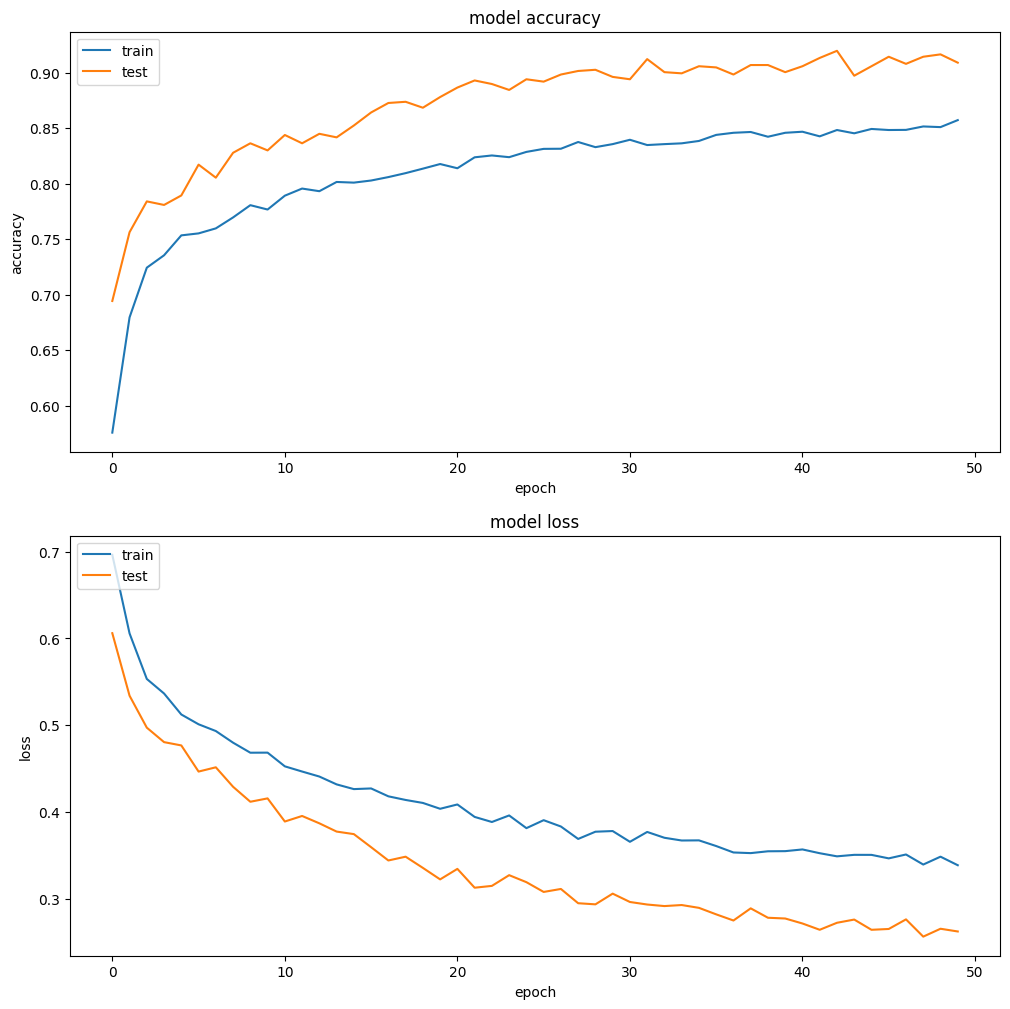

In [ ]:
plt.figure(figsize=(12,12))
# summarize history for accuracy
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
print()


filename = ''
np.save(filename + "std_from_calibration", X_std)
model_filename = os.path.join(os.getcwd(), filename + '0.7' + "trainedmodel")
# Save the model if calibration was done
clf.save(model_filename)
keras.backend.clear_session()

## Vizualize learned filters
### Raw vizualiation of 1D convolutinal kernel of the first layer --> spatial filters

In [ ]:
# # We first visualize the learned patch embeddings.
# patch_embeddings = clf.layers[0].get_weights()[0]
# weights = patch_embeddings
# # First, apply min-max normalization to the
# # given weights to avoid isotrophic scaling.
# p_min, p_max = weights.min(), weights.max()
# weights = (weights - p_min) / (p_max - p_min)

# # Visualize all the filters.
# num_filters = 10
# plt.figure(figsize=(16, 2))
# idx = 1
# for i in range(num_filters):
#     current_weight = weights[:, :, :, i]
#     if current_weight.shape[-1] == 1:
#         current_weight = current_weight.squeeze()
#     ax = plt.subplot(1, 10, idx)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     plt.plot(current_weight)
#     idx += 1

### Viz of the corresponding topo maps

In [ ]:
# spatialfilts = clf.get_layer("conv2d").get_weights()[0]
# spatialfilts = np.squeeze(spatialfilts)
# spatialfilts = np.swapaxes(spatialfilts, 1, 0)

### Predict on the test set
The predictions are made on windows to regress the code.  
Here we divide the prediction in 10 fold to avoid OOM from the GPU.

In [ ]:
keras.backend.clear_session()

In [ ]:
keras.backend.clear_session()
y_pred = clf.predict(X_test)[:,0]
y_pred = np.array(y_pred)

975/975 [==============================] - 3s 3ms/step


In [ ]:
y_pred_norm = np.array([1 if (y >= 0.5) else 0 for y in y_pred])
y_test_norm = np.array([0 if y[0] == 0 else 1 for y in Y_test])

In [ ]:
import sklearn.metrics
import math
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test_norm, y_pred_norm).ravel()
print("True positives:", tp)
print("True negatives:", tn)
print("False positives:", fp)
print("False negatives:", fn)
print("Accuracy:", (tp+tn)/len(y_test_norm))
print("Sensitivity:", sen:=tp/(tp+fn))
print("Precision:", pre:=tp/(tp+fp))
print("Fowlkes-Mallows:", math.sqrt(sen*pre))


True positives: 2826
True negatives: 20342
False positives: 5514
False negatives: 2518
Accuracy: 0.7425641025641025
Sensitivity: 0.5288173652694611
Precision: 0.33884892086330937
Fowlkes-Mallows: 0.42330744566489187


### Convert prediction on windows (regressed code) to label prediction

It is offline and synchronous, so we will:
1. First create a `code_buffer` that contains the regressed code on the full epoch (2.2s - the last window)
    - The refresh rate of the EEG device (500 Hz) is faster than the refress rate of the screen (60Hz), so we average predictions (500/60~8 samples) so they correspond to each flip of the screen.
2. Starting from `min_len` (in number of samples), we compute Pearson correalation with the bank of templates code to find the closest one
    - If the most correlated code has a significantely bigger correlation compared to the second one (50% bigger) and the p_value is significative then the trial is classified and we move to the next one
    - If the thresholds are not reached, then we add samples (with a step of 3) to have a longer trial and re-do the computation
    - The thresholds can never been reached in 2.2s, then the trial is not classified.

In [ ]:
# p_best_score = 0
# p_best_ratio = 0
# p_best_acc = 0
# p_best_values = ()

# for p in np.logspace(0,-5, 6):
#     for dr in np.linspace(0.2, 0.8, 7):
#         labels_pred, _, mean_long = make_preds_pvalue(y_pred, codes, min_len=70, sfreq=sfreq, obj_p=p)
#         ratio = len(labels_pred[labels_pred != -1])/len(labels_pred)
#         accuracy = accuracy_score(labels_test[labels_pred != -1], labels_pred[labels_pred != -1])
#         score = ratio*accuracy
#         if ratio >= p_best_ratio:
#             p_best_score = score
#             p_best_acc = accuracy
#             p_best_ratio = ratio
#             p_best_values = (p, dr)
#         print("==========", p, "+", dr,':',ratio,'--',accuracy,'--',score, '--', np.mean(mean_long))
# print("Best score", p_best_score)
# print("Best values", p_best_values)            
        

### Compute accuracy score and accuracy score when a prediction is made (discard not classified trials)

### Other classification method
Same as before but the classification method is different. Instead of thresholds to reach, if when increasing trial lengt a code correllated the most 40 times in a row then the trial is labeled.

In [ ]:
# import importlib
# importlib.reload(_utils)
# from _utils import make_preds_accumul_aggresive, make_preds_pvalue



In [ ]:
acc_best_score=0
acc_best_ratio=0
acc_best_acc=0
acc_best_value = 0
# for minlen in np.linspace(10, 60, 10):
for cons in [15, 20, 25, 30, 35, 40, 45, 50, 55, 60]:
    
    labels_pred_accumul, _, mean_long_accumul = make_preds_accumul_aggresive(
        y_pred_norm, codes, min_len=30, sfreq=sfreq, consecutive=cons, window_size=window_size
    )
    ratio = np.round(len(labels_pred_accumul[labels_pred_accumul != -1])/len(labels_pred_accumul), 2)
    accuracy = np.round(accuracy_score(labels_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1]), 2)
    score = np.round(ratio*accuracy,2)
    print("==========", cons, ':', ratio, '--', accuracy,
        '--', score, '--', np.mean(mean_long_accumul))
    if accuracy > acc_best_acc:
        acc_best_score = score
        acc_best_value = cons
        acc_best_acc = accuracy
        acc_best_ratio = ratio

print("Best accuracy", acc_best_acc)
print("Best ratio", acc_best_ratio)
print("Best score", acc_best_score)
print("Best values", acc_best_value)


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


========== 15 : 1.0 -- 0.47 -- 0.47 -- 0.8161290322580645


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


========== 20 : 1.0 -- 0.5 -- 0.5 -- 0.9569892473118279


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


========== 25 : 1.0 -- 0.53 -- 0.53 -- 1.0442528735632184


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


========== 30 : 1.0 -- 0.56 -- 0.56 -- 1.1130952380952384


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


========== 35 : 1.0 -- 0.62 -- 0.62 -- 1.2586666666666666


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


========== 40 : 1.0 -- 0.62 -- 0.62 -- 1.3763888888888889


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


========== 45 : 1.0 -- 0.72 -- 0.72 -- 1.427450980392157


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


========== 50 : 1.0 -- 0.72 -- 0.72 -- 1.4533333333333331


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


========== 55 : 1.0 -- 0.72 -- 0.72 -- 1.5153846153846153


c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


========== 60 : 1.0 -- 0.72 -- 0.72 -- 1.5680555555555555
Best accuracy 0.72
Best ratio 1.0
Best score 0.72
Best values 45


In [ ]:
accuracy_score(labels_test[labels_pred_accumul!=-1], labels_pred_accumul[labels_pred_accumul!=-1])

0.71875

In [ ]:
labels_pred_accumul, aaaaa, mean_long_accumul = make_preds_accumul_aggresive(
        y_pred_norm, codes, min_len=30, sfreq=sfreq, consecutive=15, window_size=window_size
    )

c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\s.velut\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [ ]:
len(labels_pred_accumul)


32

In [ ]:
codes

OrderedDict([(0,
              array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
                     1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0,